In [1]:
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
from path import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
#import plotly.graph_objs as go
import plotly.graph_objects as go
cf.go_offline()
cf.set_config_file(offline = True)
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import matplotlib.dates as mdates
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the trading_signals.csv file into a Pandas DataFrame
# Set the date column as the DateTimeIndex
data_path = Path("bitcoin_2010-8-16_2021-10-6.csv")
df = pd.read_csv(
    data_path,
    index_col="Date",
    infer_datetime_format=True,
    parse_dates=True
)

In [3]:
# Sorting the dataframe
df.sort_values(by=['Date'], inplace=True, ascending=True)

In [4]:
# Review the DataFrame
df.tail(10)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2021-09-27,43204.96,44237.91,42262.02,42278.31,51031440798,819023980137
2021-09-28,42111.84,42732.02,40909.31,40909.31,51750097181,789471244170
2021-09-29,41004.60,42564.99,40902.25,41543.64,50405842858,787462238462
2021-09-30,41536.59,44032.29,41466.71,43797.59,54175087118,814537665340
2021-10-01,43767.70,48388.04,43346.02,48080.37,63060539364,866976038909
2021-10-02,48147.57,48247.94,47467.84,47710.52,60614023324,900563548593
2021-10-03,47674.37,49163.40,47217.72,48144.15,47566767232,903971729927
2021-10-04,48186.65,49425.78,47004.99,49176.76,60738746937,906668798743
2021-10-05,49273.71,51785.32,49066.92,51545.05,68596958151,942701045366


In [5]:


df.head()



,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2010-08-16,0.07,0.07,0.07,0.07,0,0
2010-08-17,0.07,0.07,0.07,0.07,0,0
2010-08-18,0.07,0.07,0.07,0.07,0,0
2010-08-19,0.07,0.07,0.07,0.07,0,0
2010-08-20,0.07,0.07,0.07,0.07,0,0


In [6]:
##EXPLORATORY DATA ANALYSIS

In [7]:
# Check if there is any missing values
#df.isnull().sum()
df.isnull().values.any()

False

In [8]:


df.describe()



,Open,High,Low,Close,Volume,Market Cap
count,3979.000000,3979.000000,3979.000000,3979.000000,3.979000e+03,3.979000e+03
mean,6021.571407,6194.930148,5836.781990,6035.582566,1.148943e+10,1.092203e+11
std,11664.263409,12016.305829,11281.014648,11690.986417,2.602466e+10,2.181235e+11
min,0.060000,0.060000,0.060000,0.060000,0.000000e+00,0.000000e+00
25%,125.375000,127.370000,122.105000,125.405000,0.000000e+00,1.384740e+09
50%,625.970000,638.650000,616.610000,626.430000,6.529633e+07,9.128638e+09
75%,7439.370000,7589.780000,7294.540000,7449.175000,7.199873e+09,1.308160e+11
max,63545.120000,64816.100000,62090.500000,63528.480000,2.121515e+11,1.184937e+12


In [9]:
df_close = df['Close']
#df_close = df_close.to_frame()
#df_close.columns = [signals_df(1)]

In [10]:
df_close.head()

Date
2010-08-16    0.07
2010-08-17    0.07
2010-08-18    0.07
2010-08-19    0.07
2010-08-20    0.07
Name: Close, dtype: float64

In [11]:
# df_close.iplot(title = 'Price Change between 2010 and 2021')

In [12]:
#Calculate daily return change
ret = df_close.pct_change()
# ret.iplot(colors = 'Blue',title = 'Daily Return Between 2010 and 2021')

In [13]:
stocks_monthly_price = df_close.resample('M',kind='period').last()
ret_month = stocks_monthly_price.pct_change().dropna()
month_cum_ret = (1+ret_month).cumprod()
# month_cum_ret.iplot(color = 'Red')

In [14]:
# First thing we need to do is to normalize the data with sklearn's MinMaxScaler function. We created a function for it.
# The data will be scaled between 0 - 1

def normalize_featuresDF(df):
    """
    We created to normalize df data - range between 0-1
    args:
        df : the data we pulled up from yahoo for the stock
    return:
        normalized_features_df : data after it is normalized
    
    """
    scaler = MinMaxScaler()
    feature_columns = df.columns
    feature_minmax_data = scaler.fit_transform(df)
    normalized_features_df = pd.DataFrame(columns=feature_columns, data=feature_minmax_data, index=df.index)
    
    
    return normalized_features_df

In [15]:
##2- Split the data into Train, Test and Validation sets

In [16]:
def split_ValidationSet(features_df, target_df, length=90):
    """
    method is to separate validation set from the complete df
    args:
        features_df: full features_df
        target_df :  full target_df
        length: prediction length
    returns : 
        validation_x : returns features validations sets
        validation_y : returns target validations sets
    """
    #need to shift target array because we are prediction n + 1 days price
    target_df = target_df.shift(-1)
    #split validation set . i am spliting 10% latest data for validation.
    #target
    validation_y = target_df[-length:-1]
    validation_x = features_df[-length:-1]
    
    return validation_x, validation_y

#Now get final_features_df and final_target_df by excluding validation set
def split_Final_df(normalized_features_df, target_df, v_length=90):
    """
    This method will be having remaining data after the validation set.
    args:
        features_df: normalized features_df
        target_df: complete target_df
        v_length: validation set length
    return: 
        final_features_df : set of feature df excluding validation set
        final_target_df : set of target df excluding validation set
    """
    final_features_df = normalized_features_df[:-v_length]
    final_target_df = target_df[:-v_length]
    
    return final_features_df, final_target_df

In [17]:
##3 - Train and Test split - Timeseries split

In [18]:
#Split final set into training and testing sets
#splitting training and testing set using sklearn's TimeSeries split
def split_Train_Test_DF(final_features_df, final_target_df, n_splits=10):
    """
    Using sklearn's timeseries split to split the training and testing sets
    args:
        final_features_df: features_df after splitting validation set
        final_target_df: target_df after splitting validation set
    
    return: 
        x_train : traing feature set
        y_train : training target set
        x_test : testing feature set
        y_test : testing target set
    """
    ts_split = TimeSeriesSplit(n_splits)
    for train_index, test_index in ts_split.split(final_features_df):
        x_train, x_test = final_features_df[:len(train_index)], final_features_df[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = final_target_df[:len(train_index)].values.ravel(), final_target_df[len(train_index): (len(train_index)+len(test_index))].values.ravel()
        
    return x_train, y_train, x_test, y_test

In [19]:
##4- Visualizing the datasets

In [20]:
def DataSet_Graph():
    """
    
    Chart shows 2 different sets(Train,Test,Validation) into single plot
    Since it is time series data, it shouldnot be mixed 
    """
    t=y_test.astype(np.float)
    v = target_df[-90:-1].values.ravel()
    plt.figure(figsize = (20,10))
    plt.plot(y_train, label='trainning_set')
    plt.plot([None]*len(y_train) + [x for x in t], label='test_set')
    plt.plot([None]*(len(y_train)+len(t)) + [x for x in v], label='validation_set')
    plt.xlabel('Days',fontsize = 18)
    plt.ylabel('Price',fontsize = 18)
    plt.title('Split dataset into training/validation/test set',fontsize = 20)
    plt.legend()



In [21]:
##5 - Implementing model prediction and evaluation
##Method for validating result with evaluation metrics

In [22]:
#Method to evaluate the benchmark model and solution model with validate data set
def model_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : the model is to validate
        model_name: name of the model
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """

    model = model(x_train, y_train, validation_x)
    prediction = model.predict(validation_x)
    RMSE_Score = np.sqrt(mean_squared_error(validation_y, prediction))
    R2_Score = r2_score(validation_y, prediction)
    
    #trendline for actual vs prediction

    plt.figure(figsize = (23,10))
    plt.plot(validation_y.index, prediction, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='green', markersize=8,label = 'Prediction data')
    plt.plot(validation_y.index, validation_y, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='red', markersize=8,label = 'Actual data')
    plt.plot(figsize = (23,10))
    plt.ylabel('Price',fontsize = 20)
    plt.xlabel('Date',fontsize = 20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual',fontsize = 20)
    plt.legend(loc='upper left')
    plt.show()
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score)
    return RMSE_Score, R2_Score




#Method to evaluate the final model with testing data set
def bestModel_validateResult(model, model_name):
    """
    Returns RMSE_Score and R2_Score
    Also plots actual vs predicted trend
    args:
        model : the model is to validate
        model_name: name of the model
    return:
        RMSE_Score : calculates rmse score
        R2_Score : calculates R2 score
    """ 
    #I am giving testing set for the evaluation 
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    
    RMSE_Score = np.sqrt(mean_squared_error(y_test, prediction))
    R2_Score = r2_score(y_test, prediction)
    plt.figure(figsize = (23,10))
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(model_name + 'Prediction Vs Actual',fontsize = 20)
    plt.plot(y_test, label='test data')
    plt.plot(prediction, label='prediction')
    plt.xlabel('Days',fontsize = 20)
    plt.ylabel('Price',fontsize = 20)
    plt.legend();
    print(model_name + ' RMSE: ', RMSE_Score)
    print(model_name + ' R2 score: ', R2_Score) 
    return RMSE_Score, R2_Score



def value_Compare(model):
    """
    this method is used to create final data frame using testing value with predicted value.
    args:
        model : trained model
    return : 
        df : df with test value and predicted value
    """
    model = model(x_train, y_train, x_test)
    prediction = model.predict(x_test)
    col1 = pd.DataFrame(y_test, columns=['True_value'])
    col2 = pd.DataFrame(prediction, columns = ['Predicted_value'])
    df = pd.concat([col1, col2], axis=1)
    return df



In [23]:
#normalizing features df
normalized_features_df = normalize_featuresDF(df)
target_df = df[['Close']]

In [24]:
#Get shape of the features and target data
print("feature_df has (rows, columns) : {} ".format(normalized_features_df.shape))
print("target_df has (rows, columns) : {} ".format(target_df.shape))

feature_df has (rows, columns) : (3979, 6) 
target_df has (rows, columns) : (3979, 1) 


In [25]:
normalized_features_df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2010-08-16,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-17,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-18,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-19,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
2010-08-20,1.573686e-07,1.542828e-07,1.610554e-07,1.574099e-07,0.000000,0.000000
...,...,...,...,...,...,...
2021-10-02,7.576908e-01,7.443818e-01,7.644942e-01,7.510097e-01,0.285711,0.760010
2021-10-03,7.502442e-01,7.585058e-01,7.604659e-01,7.578355e-01,0.224211,0.762886
2021-10-04,7.583058e-01,7.625538e-01,7.570397e-01,7.740898e-01,0.286299,0.765162


In [26]:
target_df

,Close
Date,
2010-08-16,0.07
2010-08-17,0.07
2010-08-18,0.07
2010-08-19,0.07
2010-08-20,0.07
...,...
2021-10-02,47710.52
2021-10-03,48144.15
2021-10-04,49176.76


In [27]:
##Splitting train, test, validation sets

In [28]:
#Splitting validation sets from the final features and target df
validation_x, validation_y = split_ValidationSet(normalized_features_df, target_df)

In [29]:
print("validation_x has (rows, columns) : {} ".format(validation_x.shape))
print("validation_y has (rows, columns) : {} ".format(validation_y.shape))

validation_x has (rows, columns) : (89, 6) 
validation_y has (rows, columns) : (89, 1) 


In [30]:
#splitting train and test set from validation set

final_features_df, final_target_df = split_Final_df(normalized_features_df, target_df)

In [31]:
print("final_features_df has (rows, columns) : {} ".format(final_features_df.shape))
print("final_target_df has (rows, columns) : {} ".format(final_target_df.shape))

final_features_df has (rows, columns) : (3889, 6) 
final_target_df has (rows, columns) : (3889, 1) 


In [32]:
##Splitting Train and Test using Skleans TimeSeriesSplit

In [33]:
#splitting train and test
x_train, y_train, x_test, y_test = split_Train_Test_DF(final_features_df, final_target_df)

In [34]:
print("Shape of training sets x_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Shape of testing sets x_test : {}, y_test : {}".format(x_test.shape, y_test.shape))

Shape of training sets x_train : (3536, 6), y_train : (3536,)
Shape of testing sets x_test : (353, 6), y_test : (353,)


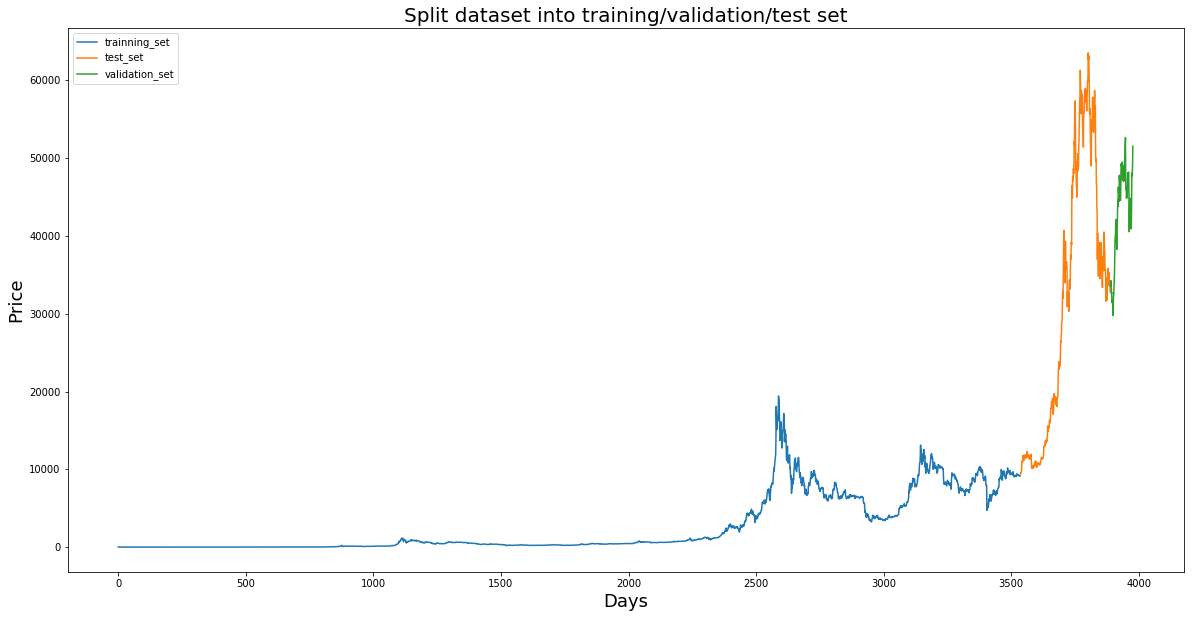

In [35]:
#Visualizing the train, test and validation sets in single plot
#Starbucks
DataSet_Graph()

### LSTM Model - Pre_work

In [36]:
# x_train and x_test were normalized already using the MinMax scaler, which is a prework requirement for LSTM
# y_train and y_test need to be scaled for the LSTM model
# y_test and y_train need to be reshaped
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)


# Fit the MinMaxScaler object with the training target data y_train
scaler = MinMaxScaler()
scaler.fit(y_train)

# Scale the target training and testing sets
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [37]:
# y_train_scaled
# y_test_scaled
# x_train.tail(20)

### LSTM Model

In [38]:
# X_train Dataframe:
# Creating the Features (X_lstm) and Target (y_lstm) data
# This function accepts the column number for the features (X) and the target (y)
def window_data(lstm_data, window, feature_col_number, target_col_number):
    X_lstm_train = []
    y_lstm_train = []
    for i in range(len(lstm_data) - window):
        features = lstm_data.iloc[i:(i + window), feature_col_number]
        target = lstm_data.iloc[(i + window), target_col_number]
        X_lstm_train.append(features)
        y_lstm_train.append(target)
    return np.array(X_lstm_train), np.array(y_lstm_train).reshape(-1, 1)

In [39]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 2

feature_column = 3
target_column = 3
X_lstm_train, y_lstm_train = window_data(x_train, window_size, feature_column, target_column)

In [40]:
print (f"X_lstm_training sample values:\n{X_lstm_train[:5]} \n")
print (f"y_lstm_training sample values:\n{y_lstm_train[:5]}")

X_lstm_training sample values:
[[1.57409865e-07 1.57409865e-07]
 [1.57409865e-07 1.57409865e-07]
 [1.57409865e-07 1.57409865e-07]
 [1.57409865e-07 1.57409865e-07]
 [1.57409865e-07 1.57409865e-07]] 

y_lstm_training sample values:
[[1.57409865e-07]
 [1.57409865e-07]
 [1.57409865e-07]
 [1.57409865e-07]
 [1.57409865e-07]]


In [41]:
# X_test Dataframe:
# Creating the Features (X_lstm) and Target (y_lstm) data
# This function accepts the column number for the features (X) and the target (y)
def window_data(lstm_data, window, feature_col_number, target_col_number):
    X_lstm_test = []
    y_lstm_test = []
    for i in range(len(lstm_data) - window):
        features = lstm_data.iloc[i:(i + window), feature_col_number]
        target = lstm_data.iloc[(i + window), target_col_number]
        X_lstm_test.append(features)
        y_lstm_test.append(target)
    return np.array(X_lstm_test), np.array(y_lstm_test).reshape(-1, 1)

In [42]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 2

feature_column = 3
target_column = 3
X_lstm_test, y_lstm_test = window_data(x_test, window_size, feature_column, target_column)

In [43]:
print (f"X_lstm_testing sample values:\n{X_lstm_test[:5]} \n")
print (f"y_lstm_testing sample values:\n{y_lstm_test[:5]}")

X_lstm_testing sample values:
[[0.14773089 0.14983593]
 [0.14983593 0.15100171]
 [0.15100171 0.15024756]
 [0.15024756 0.15246814]
 [0.15246814 0.15610809]] 

y_lstm_testing sample values:
[[0.15100171]
 [0.15024756]
 [0.15246814]
 [0.15610809]
 [0.17309544]]


In [44]:
# Keras needs to receive the features data as a vertical vector therefore, the X data was reshaped 
# Reshape the features for the model
X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))
print (f"X_train_lstm sample values:\n{X_lstm_train[:5]} \n")
print (f"X_test_lstm sample values:\n{X_lstm_test[:5]}")

X_train_lstm sample values:
[[[1.57409865e-07]
  [1.57409865e-07]]

 [[1.57409865e-07]
  [1.57409865e-07]]

 [[1.57409865e-07]
  [1.57409865e-07]]

 [[1.57409865e-07]
  [1.57409865e-07]]

 [[1.57409865e-07]
  [1.57409865e-07]]] 

X_test_lstm sample values:
[[[0.14773089]
  [0.14983593]]

 [[0.14983593]
  [0.15100171]]

 [[0.15100171]
  [0.15024756]]

 [[0.15024756]
  [0.15246814]]

 [[0.15246814]
  [0.15610809]]]


In [45]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [46]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_lstm_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [47]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [48]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 5)              140       
_________________________________________________________________
dropout (Dropout)            (None, 2, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [49]:
# Train the model
model.fit(X_lstm_train, y_lstm_train, epochs=100, shuffle=False, batch_size=32, verbose=1)

Epoch 1/100
111/111 [==============================] - 6s 6ms/step - loss: 0.0014
Epoch 2/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0044
Epoch 3/100
111/111 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 4/100
111/111 [==============================] - 1s 8ms/step - loss: 0.0040A: 0s -
Epoch 5/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0036
Epoch 6/100
111/111 [==============================] - 1s 7ms/step - loss: 0.0030
Epoch 7/100
111/111 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 8/100
111/111 [==============================] - 1s 6ms/step - loss: 0.0012
Epoch 9/100
111/111 [==============================] - 1s 7ms/step - loss: 8.2558e-04
Epoch 10/100
111/111 [==============================] - 1s 7ms/step - loss: 6.4804e-04
Epoch 11/100
111/111 [==============================] - 1s 7ms/step - loss: 5.9461e-04
Epoch 12/100
111/111 [==============================] - 1s 7ms/step - loss: 6

### LSTM Model

In [50]:
# Evaluate the model
model_3d = model.evaluate(X_lstm_test, y_lstm_test)

11/11 [==============================] - 1s 2ms/step - loss: 0.0852 


In [51]:
print (f"Loss of the Model Using 3-day window:{model_3d}" )

Loss of the Model Using 3-day window:0.0851905569434166


In [52]:
# Make some predictions
predicted_lstm = model.predict(X_lstm_test)

In [53]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted_lstm)
real_prices = scaler.inverse_transform(y_lstm_test.reshape(-1, 1))

In [54]:
# Create a DataFrame of Real and Predicted values
lstm_comparison = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = x_train.index[-len(real_prices): ])
lstm_comparison.head()

,Real,Predicted
Date,,
2019-08-05,2933.632114,2697.003418
2019-08-06,2918.980920,2732.125977
2019-08-07,2962.121057,2744.613525
2019-08-08,3032.835775,2745.174316
2019-08-09,3362.856139,2794.250000


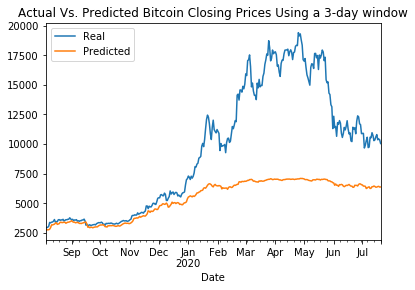

In [55]:
# Plot the real vs predicted prices as a line chart

lstm_comparison.plot(title="Actual Vs. Predicted Bitcoin Closing Prices Using a 3-day window")

In [56]:
# RMSE and r2 Scores for comparison
RMSE_Score_LSTM = np.sqrt(mean_squared_error(y_lstm_test, predicted_lstm))
print('RMSE score for LSTM model is', RMSE_Score_LSTM)

RMSE score for LSTM model is 0.2918742198650712


In [58]:
r2_LSTM = -r2_score(y_lstm_test, predicted_lstm)
print('r2 score for LSTM model is', r2_LSTM)

r2 score for LSTM model is 0.13545814690074476
